In [1]:
!pip install statsmodels

Fetching datasets...
Dataset shape: (227, 6)
Correlation between PM2.5 and Mortality: 0.509


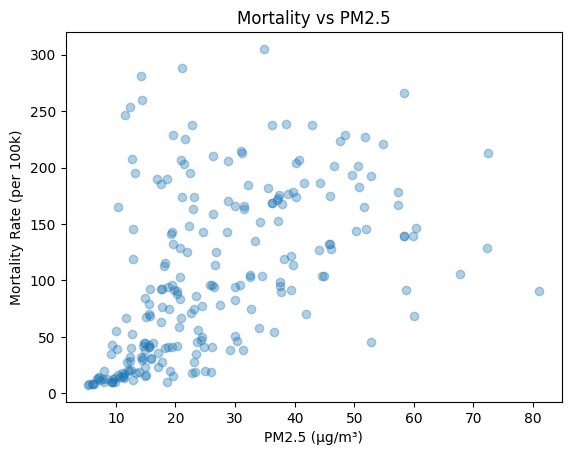

                            OLS Regression Results                            
Dep. Variable:              mort_rate   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     78.78
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           2.21e-16
Time:                        08:50:21   Log-Likelihood:                -1265.0
No. Observations:                 227   AIC:                             2534.
Df Residuals:                     225   BIC:                             2541.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.8765      8.515      4.331      0.0

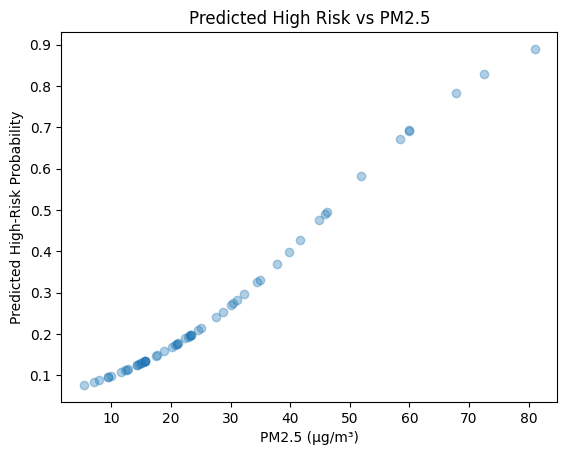

In [2]:
# Air Pollution Health Impact Analysis in Colab

import os, time, requests
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Indicators
IND_PM25 = "EN.ATM.PM25.MC.M3"   # PM2.5 exposure
IND_MORT = "SH.STA.AIRP.P5"      # Mortality rate
WDI_API = "https://api.worldbank.org/v2/country/all/indicator/{indicator}?format=json&per_page=20000"

# ---------------------------
# Fetch WDI function
# ---------------------------
def fetch_wdi(indicator):
    url = WDI_API.format(indicator=indicator)
    all_rows = []
    page = 1
    while True:
        r = requests.get(url + f"&page={page}", timeout=60)
        r.raise_for_status()
        data = r.json()
        if not isinstance(data, list) or len(data) < 2:
            break
        meta, rows = data
        if rows is None:
            break
        for item in rows:
            if not item:
                continue
            iso3c = item.get("countryiso3code")
            year  = item.get("date")
            val   = item.get("value")
            country = item.get("country", {}).get("value")
            if iso3c and len(iso3c) == 3 and year.isdigit():
                all_rows.append([country, iso3c, int(year), val])
        if page >= meta.get("pages", 1):
            break
        page += 1
        time.sleep(0.1)
    df = pd.DataFrame(all_rows, columns=["country","iso3c","year","value"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    return df.dropna(subset=["value"])

# ---------------------------
# Main analysis
# ---------------------------
print("Fetching datasets...")
df_pm = fetch_wdi(IND_PM25).rename(columns={"value":"pm25"})
df_mort = fetch_wdi(IND_MORT).rename(columns={"value":"mort_rate"})

df = pd.merge(df_pm, df_mort, on=["iso3c","year"], suffixes=("_pm","_mort"))
df = df.dropna(subset=["pm25","mort_rate"]).sort_values(["iso3c","year"])
print("Dataset shape:", df.shape)

# Save dataset in Colab
df.to_csv("merged_wdi_pm25_mortality.csv", index=False)

# ---------------------------
# Correlation
# ---------------------------
corr = df[["pm25","mort_rate"]].corr().iloc[0,1]
print("Correlation between PM2.5 and Mortality:", round(corr,3))

plt.scatter(df["pm25"], df["mort_rate"], alpha=0.35)
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Mortality Rate (per 100k)")
plt.title("Mortality vs PM2.5")
plt.show()

# ---------------------------
# Regression (OLS)
# ---------------------------
X = sm.add_constant(df["pm25"])
y = df["mort_rate"]
model = sm.OLS(y, X).fit()
print(model.summary())

# ---------------------------
# Logistic Regression Risk Model
# ---------------------------
df["year_cut"] = df.groupby("year")["mort_rate"].transform(lambda s: s.quantile(0.75))
df["high_risk"] = (df["mort_rate"] >= df["year_cut"]).astype(int)

X = df[["pm25"]]
y = df["high_risk"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:,1]

print("Risk Model Accuracy:", accuracy_score(y_test,y_pred))
print("Risk Model ROC-AUC:", roc_auc_score(y_test,y_proba))

plt.scatter(X_test, y_proba, alpha=0.35)
plt.xlabel("PM2.5 (µg/m³)")
plt.ylabel("Predicted High-Risk Probability")
plt.title("Predicted High Risk vs PM2.5")
plt.show()
